# K- Nearest Neighbors on Amazon Food Reviews

In [20]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# General Packages
import os
import sqlite3
import pandas as pd
import numpy as np
import string
import re
import nltk
import datetime
import time

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Tfidf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Packages for BOW (Bag of words)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# Packages for Text Preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#Packages for Word2vec, Average Word2vec & Tf-Idf Weighted Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

#Packages for plotting Tsne plot
from sklearn.manifold import TSNE

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import TimeSeriesSplit
from prettytable import PrettyTable
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.decomposition import TruncatedSVD

In [2]:
# Formaing Output using pretty table
x = PrettyTable(["Model","Algorithm"," K ","TPR","TNR","Precision","Recall","F1-Score","FPR","FNR","PPV","NPV","Overall Accuracy (ACC)"])
from prettytable import MSWORD_FRIENDLY
x.set_style(MSWORD_FRIENDLY)
print(x)

| Model | Algorithm |  K  | TPR | TNR | Precision | Recall | F1-Score | FPR | FNR | PPV | NPV | Overall Accuracy (ACC) |


### Preprocessing Stage: Cleansed Stop Words, Punctuations & Html tags

In [3]:
#Connecting the Sqlite file after the Preprocessing Stage
os.chdir('/Users/sujis/Downloads/AI/Sujit')
con = sqlite3.connect('final.sqlite') 
final= pd.read_sql_query(""" SELECT * FROM Reviews """, con) 

In [4]:
final.head(1)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [5]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

## Considering 50K data for KNN with 'Brute' Algorithm

In [209]:
# Taking 75K data points from the dataset
final_dataset=final.head(50000)

In [210]:
final_dataset['Score'].value_counts()

positive    42540
negative     7460
Name: Score, dtype: int64

In [211]:
#Sorting the Dataframe with Date to apply Timebased Split
final_dataset=final_dataset.sort_values(by='Time',ascending=1)

In [212]:
# create design matrix X and target vector y
X = np.array(final_dataset.iloc[:, 0:12]) # end index is exclusive
Y = np.array(final_dataset['Score']) # showing you two ways of indexing a pandas df

In [213]:
#Time based split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [214]:
#Splitting the Dataset into Train set & Test set
for train_index, test_index in tscv.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_tr, X_test = X[train_index], X[test_index]
   Y_tr, Y_test = Y[train_index], Y[test_index]

TRAIN: [   0    1    2 ... 8332 8333 8334] TEST: [ 8335  8336  8337 ... 16665 16666 16667]
TRAIN: [    0     1     2 ... 16665 16666 16667] TEST: [16668 16669 16670 ... 24998 24999 25000]
TRAIN: [    0     1     2 ... 24998 24999 25000] TEST: [25001 25002 25003 ... 33331 33332 33333]
TRAIN: [    0     1     2 ... 33331 33332 33333] TEST: [33334 33335 33336 ... 41664 41665 41666]
TRAIN: [    0     1     2 ... 41664 41665 41666] TEST: [41667 41668 41669 ... 49997 49998 49999]


In [215]:
# Splitting the Train dataset into Cross Validation & Train Datasets
for train_index, test_index in tscv.split(X_tr):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_cv = X[train_index], X[test_index]
   Y_train, Y_cv = Y[train_index], Y[test_index]

TRAIN: [   0    1    2 ... 6944 6945 6946] TEST: [ 6947  6948  6949 ... 13888 13889 13890]
TRAIN: [    0     1     2 ... 13888 13889 13890] TEST: [13891 13892 13893 ... 20832 20833 20834]
TRAIN: [    0     1     2 ... 20832 20833 20834] TEST: [20835 20836 20837 ... 27776 27777 27778]
TRAIN: [    0     1     2 ... 27776 27777 27778] TEST: [27779 27780 27781 ... 34720 34721 34722]
TRAIN: [    0     1     2 ... 34720 34721 34722] TEST: [34723 34724 34725 ... 41664 41665 41666]


In [216]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)
print('-------------------')
print(Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)

(34723, 12)
(6944, 12)
(8333, 12)
-------------------
(34723,)
(6944,)
(8333,)


In [217]:
# Converting X_Train, X_cv & X_test data is  to Dataframe for the ease of use
X_train_data=pd.DataFrame(X_train, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText']) 

X_cv_data=pd.DataFrame(X_cv, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText']) 

X_test_data=pd.DataFrame(X_test, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText']) 


## Bag of Words

In [218]:
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(X_train_data['CleanedText'].values)
# Bag of Words : Train Data Set
Train_X_vector = vectorizer.transform(X_train_data['CleanedText'].values)
# summarize encoded vector
print(Train_X_vector.shape)

(34723, 23935)


In [219]:
# Cross Validation Data Set
CV_X_vector = vectorizer.transform(X_cv_data['CleanedText'].values)
print(CV_X_vector.shape)

(6944, 23935)


In [220]:
#Test Data Set
Test_X_vector = vectorizer.transform(X_test_data['CleanedText'].values)
print(Test_X_vector.shape)

(8333, 23935)


In [221]:
print(Train_X_vector.shape)
print(CV_X_vector.shape)
print(Test_X_vector.shape)
print('-------------------')
print(Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)

(34723, 23935)
(6944, 23935)
(8333, 23935)
-------------------
(34723,)
(6944,)
(8333,)


In [222]:
start_time_code = time.time()
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="brute")

    # fitting the model on crossvalidation train
    knn.fit(Train_X_vector, Y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(CV_X_vector)

    # evaluate CV accuracy
    bag_acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %0.1f%%' % (i, bag_acc))
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")


CV accuracy for k = 1 is 77.0%

CV accuracy for k = 3 is 81.8%

CV accuracy for k = 5 is 82.7%

CV accuracy for k = 7 is 82.7%

CV accuracy for k = 9 is 82.7%

CV accuracy for k = 11 is 82.7%

CV accuracy for k = 13 is 82.7%

CV accuracy for k = 15 is 82.7%

CV accuracy for k = 17 is 82.6%

CV accuracy for k = 19 is 82.5%

CV accuracy for k = 21 is 82.5%

CV accuracy for k = 23 is 82.5%

CV accuracy for k = 25 is 82.5%

CV accuracy for k = 27 is 82.5%

CV accuracy for k = 29 is 82.6%
Running Time for code execution 231.88899397850037 secs


In [223]:
knn = KNeighborsClassifier(15,algorithm="brute")
knn.fit(Train_X_vector,Y_train)
pred = knn.predict(Test_X_vector)
bag_test_acc = accuracy_score(Y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 15 is %0.2f%%' % (bag_test_acc))


****Test accuracy for k = 15 is 81.70%


In [224]:
Conf_matrix=confusion_matrix(Y_test, pred)

In [225]:
Conf_matrix

array([[  29, 1520],
       [   5, 6779]])

In [226]:
# Function for plotting Confusion Matrix
# Using this snipped of code copied from kaggle
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

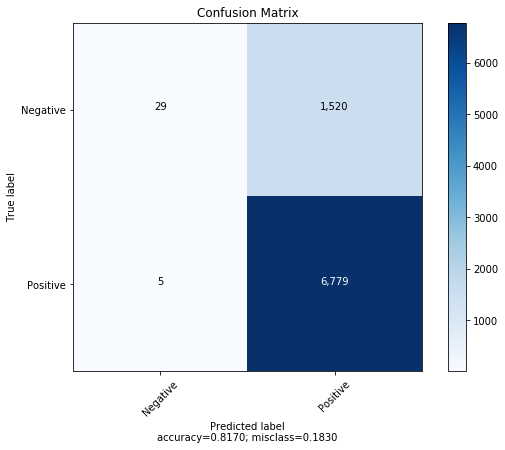

In [227]:
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

In [228]:
Conf_matrix

array([[  29, 1520],
       [   5, 6779]])

In [229]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [230]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format( TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format( TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format( FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format( FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format( TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format( TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format( (TP+TN)/(TP+FP+FN+TN))

In [231]:
Recall=recall_score(Y_test, pred, average='micro') 

In [232]:
Precision=precision_score(Y_test, pred, average='micro')

In [233]:
F1_Score=f1_score(Y_test, pred, average='weighted')

In [234]:
pd.crosstab(Y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,negative,positive,All
True,,,
negative,29,1520,1549
positive,5,6779,6784
All,34,8299,8333


In [235]:
x.add_row(["Bag of Words","Brute",15,TPR,TNR,'{0:.2f}'.format(Precision),'{0:.2f}'.format(Recall),'{0:.2f}'.format(F1_Score),FPR,FNR,PPV,NPV,ACC])

In [236]:
print(x)

|          Model          | Algorithm |  K  |  TPR   |  TNR   | Precision | Recall | F1-Score |  FPR   |  FNR  |  PPV   |  NPV   | Overall Accuracy (ACC) |
|       Bag of Words      |  kd_tree  |  17 | 99.07% | 7.29%  |    0.82   |  0.82  |   0.76   | 92.71% | 0.93% | 82.33% | 64.15% |         81.94%         |
|         TF - IDF        |  Kd_tree  |  13 | 99.09% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.91% | 82.90% | 73.38% |         82.64%         |
|       Average W2V       |  Kd_tree  |  11 | 98.25% | 18.11% |    0.83   |  0.83  |   0.79   | 81.89% | 1.75% | 83.95% | 70.42% |         83.30%         |
|  TF - IDF Weighted W2V  |  Kd_tree  |  23 | 99.34% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.66% | 82.94% | 79.07% |         82.84%         |
|       Bag of Words      |   Brute   |  15 | 99.93% | 1.87%  |    0.82   |  0.82  |   0.74   | 98.13% | 0.07% | 81.68% | 85.29% |         81.70%         |


In [237]:
print(classification_report(Y_test, pred))  

             precision    recall  f1-score   support

   negative       0.85      0.02      0.04      1549
   positive       0.82      1.00      0.90      6784

avg / total       0.82      0.82      0.74      8333



## TF - IDF

In [238]:
tf_transformer = TfidfVectorizer(ngram_range=(1,2))
TF_vector=tf_transformer.fit(X_train_data['CleanedText'].values)
TF_train_Vector = TF_vector.transform(X_train_data['CleanedText'].values)
TF_train_Vector.shape

(34723, 598035)

In [239]:
TF_cv_Vector = TF_vector.transform(X_cv_data['CleanedText'].values)
TF_cv_Vector.shape

(6944, 598035)

In [240]:
TF_test_Vector = TF_vector.transform(X_test_data['CleanedText'].values)
TF_test_Vector.shape

(8333, 598035)

In [241]:
print(TF_train_Vector.shape)
print(TF_cv_Vector.shape)
print(TF_test_Vector.shape)
print('-------------------')
print(Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)

(34723, 598035)
(6944, 598035)
(8333, 598035)
-------------------
(34723,)
(6944,)
(8333,)


In [242]:
start_time_code = time.time()
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="brute")

    # fitting the model on crossvalidation train
    knn.fit(TF_train_Vector, Y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(TF_cv_Vector)

    # evaluate CV accuracy
    tf_acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %0.2f%%' % (i, tf_acc))
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")


CV accuracy for k = 1 is 80.04%

CV accuracy for k = 3 is 83.19%

CV accuracy for k = 5 is 83.60%

CV accuracy for k = 7 is 83.81%

CV accuracy for k = 9 is 83.68%

CV accuracy for k = 11 is 83.80%

CV accuracy for k = 13 is 83.74%

CV accuracy for k = 15 is 83.60%

CV accuracy for k = 17 is 83.50%

CV accuracy for k = 19 is 83.40%

CV accuracy for k = 21 is 83.40%

CV accuracy for k = 23 is 83.35%

CV accuracy for k = 25 is 83.31%

CV accuracy for k = 27 is 83.35%

CV accuracy for k = 29 is 83.37%
Running Time for code execution 213.33067083358765 secs


In [243]:
knn = KNeighborsClassifier(11,algorithm="brute")
knn.fit(TF_train_Vector,Y_train)
pred = knn.predict(TF_test_Vector)
tf_test_acc = accuracy_score(Y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 11 is %0.2f%%' % (tf_test_acc))


****Test accuracy for k = 11 is 82.91%


In [244]:
Conf_matrix=confusion_matrix(Y_test, pred)

In [245]:
Conf_matrix

array([[ 190, 1359],
       [  65, 6719]])

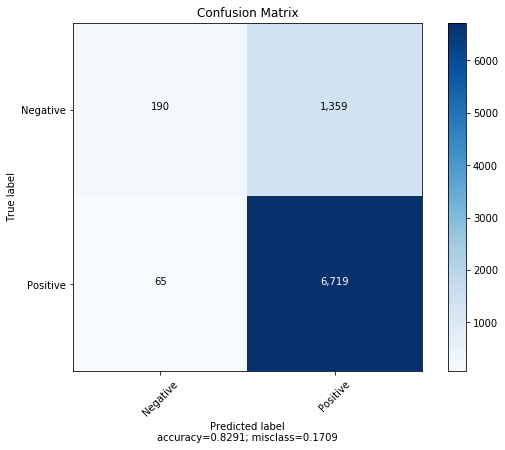

In [246]:
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

In [247]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [248]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format( TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format( TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format( FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format( FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format( TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format( TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format( (TP+TN)/(TP+FP+FN+TN))

In [249]:
Recall=recall_score(Y_test, pred, average='micro') 

In [250]:
Precision=precision_score(Y_test, pred, average='micro')

In [251]:
F1_Score=f1_score(Y_test, pred, average='weighted')

In [252]:
pd.crosstab(Y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,negative,positive,All
True,,,
negative,190,1359,1549
positive,65,6719,6784
All,255,8078,8333


In [253]:
x.add_row(["TF - IDF","Brute",11,TPR,TNR,'{0:.2f}'.format(Precision),'{0:.2f}'.format(Recall),'{0:.2f}'.format(F1_Score),FPR,FNR,PPV,NPV,ACC])

In [254]:
print(classification_report(Y_test, pred))  

             precision    recall  f1-score   support

   negative       0.75      0.12      0.21      1549
   positive       0.83      0.99      0.90      6784

avg / total       0.82      0.83      0.78      8333



In [255]:
print(x)

|          Model          | Algorithm |  K  |  TPR   |  TNR   | Precision | Recall | F1-Score |  FPR   |  FNR  |  PPV   |  NPV   | Overall Accuracy (ACC) |
|       Bag of Words      |  kd_tree  |  17 | 99.07% | 7.29%  |    0.82   |  0.82  |   0.76   | 92.71% | 0.93% | 82.33% | 64.15% |         81.94%         |
|         TF - IDF        |  Kd_tree  |  13 | 99.09% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.91% | 82.90% | 73.38% |         82.64%         |
|       Average W2V       |  Kd_tree  |  11 | 98.25% | 18.11% |    0.83   |  0.83  |   0.79   | 81.89% | 1.75% | 83.95% | 70.42% |         83.30%         |
|  TF - IDF Weighted W2V  |  Kd_tree  |  23 | 99.34% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.66% | 82.94% | 79.07% |         82.84%         |
|       Bag of Words      |   Brute   |  15 | 99.93% | 1.87%  |    0.82   |  0.82  |   0.74   | 98.13% | 0.07% | 81.68% | 85.29% |         81.70%         |
|         TF - IDF        |   Brute   |  11 | 99.04% | 12.27% | 

## Average W2V

In [256]:
# Train your own Word2Vec model using your own text corpus for Training Dataset
i=0
list_of_sent=[]
for sent in X_train_data['CleanedText'].values:
    list_of_sent.append(sent.split())

# min_count = 5 considers only words that occured atleast 5 times
Trained_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

w2v_words = list(Trained_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8321
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school']


In [257]:
# average Word2Vec
# compute average word2vec for each review.
start_time_code = time.time()
Trained_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Trained_vectors.append(sent_vec)
print(len(Trained_vectors))
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

34723
Running Time for code execution 62.595484018325806 secs


In [258]:
Train_X=Trained_vectors

In [260]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_cv=[]
for sent in X_cv_data['CleanedText'].values:
    list_of_sent_cv.append(sent.split())

In [261]:
# average Word2Vec
# compute average word2vec for each review.
start_time_code = time.time()
Cv_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Cv_vectors.append(sent_vec)
print(len(Cv_vectors))
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

6944
Running Time for code execution 11.396867990493774 secs


In [262]:
CV_X=Cv_vectors

In [264]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_test=[]
for sent in X_test_data['CleanedText'].values:
    list_of_sent_test.append(sent.split())

In [265]:
# average Word2Vec
# compute average word2vec for each review.
start_time_code = time.time()
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

8333
Running Time for code execution 14.642790079116821 secs


In [266]:
Test_X=test_vectors

In [267]:
print (len(Train_X))
print(len(CV_X))
print(len(Test_X))
print('-----------------')
print (Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)

34723
6944
8333
-----------------
(34723,)
(6944,)
(8333,)


In [268]:
start_time_code = time.time()
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="brute")

    # fitting the model on crossvalidation train
    knn.fit(Train_X, Y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(CV_X)

    # evaluate CV accuracy
    train_acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %0.2f%%' % (i, train_acc))
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")


CV accuracy for k = 1 is 80.17%

CV accuracy for k = 3 is 83.45%

CV accuracy for k = 5 is 84.12%

CV accuracy for k = 7 is 84.48%

CV accuracy for k = 9 is 84.59%

CV accuracy for k = 11 is 84.53%

CV accuracy for k = 13 is 84.48%

CV accuracy for k = 15 is 84.48%

CV accuracy for k = 17 is 84.56%

CV accuracy for k = 19 is 84.52%

CV accuracy for k = 21 is 84.45%

CV accuracy for k = 23 is 84.36%

CV accuracy for k = 25 is 84.38%

CV accuracy for k = 27 is 84.25%

CV accuracy for k = 29 is 84.17%
Running Time for code execution 105.32548975944519 secs


In [269]:
# Since the train accuracy for k is the same from k=3 to k=29. so the smallest k at maximum accuracy is the best i.e. k=3
knn = KNeighborsClassifier(17,algorithm="brute")
knn.fit(Train_X,Y_train)
pred = knn.predict(Test_X)
test_acc = accuracy_score(Y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 17 is %0.2f%%' % (test_acc))


****Test accuracy for k = 17 is 83.96%


In [270]:
Conf_matrix=confusion_matrix(Y_test, pred)

In [271]:
Conf_matrix

array([[ 323, 1226],
       [ 111, 6673]])

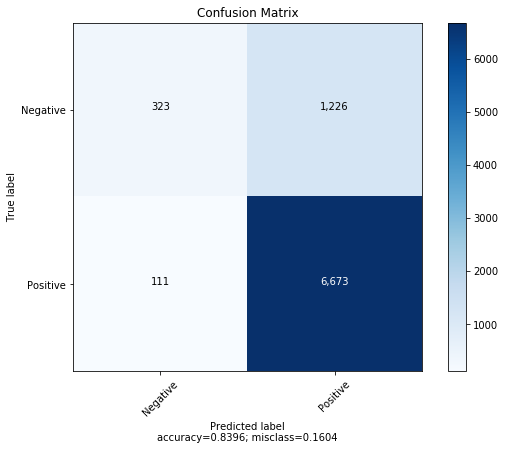

In [272]:
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

In [273]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [274]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format( TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format( TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format( FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format( FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format( TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format( TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format( (TP+TN)/(TP+FP+FN+TN))

In [275]:
Recall=recall_score(Y_test, pred, average='micro') 

In [276]:
Precision=precision_score(Y_test, pred, average='micro')

In [277]:
F1_Score=f1_score(Y_test, pred, average='weighted')

In [278]:
pd.crosstab(Y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,negative,positive,All
True,,,
negative,323,1226,1549
positive,111,6673,6784
All,434,7899,8333


In [279]:
x.add_row([" Average W2V","Brute",17,TPR,TNR,'{0:.2f}'.format(Precision),'{0:.2f}'.format(Recall),'{0:.2f}'.format(F1_Score),FPR,FNR,PPV,NPV,ACC])

In [280]:
print(classification_report(Y_test, pred))  

             precision    recall  f1-score   support

   negative       0.74      0.21      0.33      1549
   positive       0.84      0.98      0.91      6784

avg / total       0.83      0.84      0.80      8333



In [281]:
print(x)

|          Model          | Algorithm |  K  |  TPR   |  TNR   | Precision | Recall | F1-Score |  FPR   |  FNR  |  PPV   |  NPV   | Overall Accuracy (ACC) |
|       Bag of Words      |  kd_tree  |  17 | 99.07% | 7.29%  |    0.82   |  0.82  |   0.76   | 92.71% | 0.93% | 82.33% | 64.15% |         81.94%         |
|         TF - IDF        |  Kd_tree  |  13 | 99.09% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.91% | 82.90% | 73.38% |         82.64%         |
|       Average W2V       |  Kd_tree  |  11 | 98.25% | 18.11% |    0.83   |  0.83  |   0.79   | 81.89% | 1.75% | 83.95% | 70.42% |         83.30%         |
|  TF - IDF Weighted W2V  |  Kd_tree  |  23 | 99.34% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.66% | 82.94% | 79.07% |         82.84%         |
|       Bag of Words      |   Brute   |  15 | 99.93% | 1.87%  |    0.82   |  0.82  |   0.74   | 98.13% | 0.07% | 81.68% | 85.29% |         81.70%         |
|         TF - IDF        |   Brute   |  11 | 99.04% | 12.27% | 

## TF-IDF weighted Word2Vec

In [26]:
# TF-IDF weighted Word2Vec
tfidf_feat = TF_vector.get_feature_names() # tfidf words/col-names

In [87]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
start_time_code = time.time()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = TF_train_Vector[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

Running Time for code execution 28771.18012213707 secs


In [88]:
Train_X=tfidf_sent_vectors

In [89]:
df = pd.DataFrame.from_records(Train_X)
df.to_csv('TF-IDF_W2V_Train.csv',index=None)

In [282]:
Train_X = pd.read_csv("TF-IDF_W2V_Train.csv") 

In [116]:
len(Train_X)

34723

In [92]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
start_time_code = time.time()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = TF_cv_Vector[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

Running Time for code execution 5836.9589948654175 secs


In [93]:
CV_X=tfidf_sent_vectors

In [94]:
df = pd.DataFrame.from_records(CV_X)
df.to_csv('TF-IDF_W2V_CV.csv',index=None)

In [283]:
CV_X = pd.read_csv("TF-IDF_W2V_CV.csv") 

In [27]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
start_time_code = time.time()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = TF_test_Vector[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

Running Time for code execution 7043.685368061066 secs


In [28]:
Test_X=tfidf_sent_vectors

In [29]:
df = pd.DataFrame.from_records(Test_X)
df.to_csv('TF-IDF_W2V_test.csv',index=None)

In [284]:
Test_X = pd.read_csv("TF-IDF_W2V_test.csv") 

In [285]:
start_time_code = time.time()
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="brute")

    # fitting the model on crossvalidation train
    knn.fit(Train_X, Y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(CV_X)

    # evaluate CV accuracy
    train_acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %0.2f%%' % (i, train_acc))
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")


CV accuracy for k = 1 is 80.11%

CV accuracy for k = 3 is 82.75%

CV accuracy for k = 5 is 83.55%

CV accuracy for k = 7 is 83.73%

CV accuracy for k = 9 is 83.94%

CV accuracy for k = 11 is 83.71%

CV accuracy for k = 13 is 83.67%

CV accuracy for k = 15 is 83.50%

CV accuracy for k = 17 is 83.53%

CV accuracy for k = 19 is 83.44%

CV accuracy for k = 21 is 83.48%

CV accuracy for k = 23 is 83.38%

CV accuracy for k = 25 is 83.45%

CV accuracy for k = 27 is 83.38%

CV accuracy for k = 29 is 83.41%
Running Time for code execution 100.78603434562683 secs


In [286]:
# Since the train accuracy for k is the same from k=3 to k=29. so the smallest k at maximum accuracy is the best i.e. k=3
knn = KNeighborsClassifier(9,algorithm="brute")
knn.fit(Train_X,Y_train)
pred = knn.predict(Test_X)
test_acc = accuracy_score(Y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 9 is %0.2f%%' % (test_acc))


****Test accuracy for k = 9 is 80.88%


In [287]:
Conf_matrix=confusion_matrix(Y_test, pred)

In [288]:
Conf_matrix

array([[  32, 1517],
       [  76, 6708]])

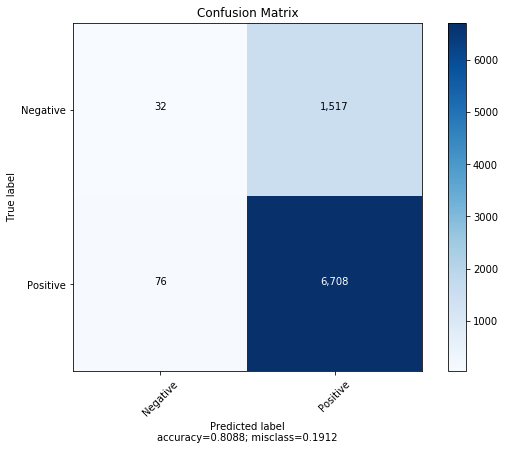

In [289]:
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

In [290]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [291]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format( TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format( TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format( FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format( FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format( TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format( TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format( (TP+TN)/(TP+FP+FN+TN))

In [292]:
Recall=recall_score(Y_test, pred, average='micro') 

In [293]:
Precision=precision_score(Y_test, pred, average='micro')

In [294]:
F1_Score=f1_score(Y_test, pred, average='weighted')

In [295]:
pd.crosstab(Y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,negative,positive,All
True,,,
negative,32,1517,1549
positive,76,6708,6784
All,108,8225,8333


In [296]:
x.add_row([" TF-IDF Weighted W2V ","Brute",17,TPR,TNR,'{0:.2f}'.format(Precision),'{0:.2f}'.format(Recall),'{0:.2f}'.format(F1_Score),FPR,FNR,PPV,NPV,ACC])

In [297]:
print(classification_report(Y_test, pred))  

             precision    recall  f1-score   support

   negative       0.30      0.02      0.04      1549
   positive       0.82      0.99      0.89      6784

avg / total       0.72      0.81      0.73      8333



In [298]:
print(x)

|          Model          | Algorithm |  K  |  TPR   |  TNR   | Precision | Recall | F1-Score |  FPR   |  FNR  |  PPV   |  NPV   | Overall Accuracy (ACC) |
|       Bag of Words      |  kd_tree  |  17 | 99.07% | 7.29%  |    0.82   |  0.82  |   0.76   | 92.71% | 0.93% | 82.33% | 64.15% |         81.94%         |
|         TF - IDF        |  Kd_tree  |  13 | 99.09% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.91% | 82.90% | 73.38% |         82.64%         |
|       Average W2V       |  Kd_tree  |  11 | 98.25% | 18.11% |    0.83   |  0.83  |   0.79   | 81.89% | 1.75% | 83.95% | 70.42% |         83.30%         |
|  TF - IDF Weighted W2V  |  Kd_tree  |  23 | 99.34% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.66% | 82.94% | 79.07% |         82.84%         |
|       Bag of Words      |   Brute   |  15 | 99.93% | 1.87%  |    0.82   |  0.82  |   0.74   | 98.13% | 0.07% | 81.68% | 85.29% |         81.70%         |
|         TF - IDF        |   Brute   |  11 | 99.04% | 12.27% | 

## Considering 30K data for KNN with 'kd_tree' Algorithm

In [6]:
# Taking 75K data points from the dataset
final_dataset=final.head(30000)

In [7]:
final_dataset['Score'].value_counts()

positive    25494
negative     4506
Name: Score, dtype: int64

In [8]:
#Sorting the Dataframe with Date to apply Timebased Split
final_dataset=final_dataset.sort_values(by='Time',ascending=1)

In [9]:
# create design matrix X and target vector y
X = np.array(final_dataset.iloc[:, 0:12]) # end index is exclusive
Y = np.array(final_dataset['Score']) # showing you two ways of indexing a pandas df

In [10]:
#Time based split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [11]:
#Splitting the Dataset into Train set & Test set
for train_index, test_index in tscv.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_tr, X_test = X[train_index], X[test_index]
   Y_tr, Y_test = Y[train_index], Y[test_index]

TRAIN: [   0    1    2 ... 4997 4998 4999] TEST: [5000 5001 5002 ... 9997 9998 9999]
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [10000 10001 10002 ... 14997 14998 14999]
TRAIN: [    0     1     2 ... 14997 14998 14999] TEST: [15000 15001 15002 ... 19997 19998 19999]
TRAIN: [    0     1     2 ... 19997 19998 19999] TEST: [20000 20001 20002 ... 24997 24998 24999]
TRAIN: [    0     1     2 ... 24997 24998 24999] TEST: [25000 25001 25002 ... 29997 29998 29999]


In [12]:
# Splitting the Train dataset into Cross Validation & Train Datasets
for train_index, test_index in tscv.split(X_tr):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_cv = X[train_index], X[test_index]
   Y_train, Y_cv = Y[train_index], Y[test_index]

TRAIN: [   0    1    2 ... 4167 4168 4169] TEST: [4170 4171 4172 ... 8333 8334 8335]
TRAIN: [   0    1    2 ... 8333 8334 8335] TEST: [ 8336  8337  8338 ... 12499 12500 12501]
TRAIN: [    0     1     2 ... 12499 12500 12501] TEST: [12502 12503 12504 ... 16665 16666 16667]
TRAIN: [    0     1     2 ... 16665 16666 16667] TEST: [16668 16669 16670 ... 20831 20832 20833]
TRAIN: [    0     1     2 ... 20831 20832 20833] TEST: [20834 20835 20836 ... 24997 24998 24999]


In [13]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)
print('-------------------')
print(Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)

(20834, 12)
(4166, 12)
(5000, 12)
-------------------
(20834,)
(4166,)
(5000,)


In [14]:
# Converting X_Train, X_cv & X_test data is  to Dataframe for the ease of use
X_train_data=pd.DataFrame(X_train, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText']) 

X_cv_data=pd.DataFrame(X_cv, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText']) 

X_test_data=pd.DataFrame(X_test, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText']) 


## Bag of Words

In [118]:
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(X_train_data['CleanedText'].values)
# Bag of Words : Train Data Set
Train_X_vector = vectorizer.transform(X_train_data['CleanedText'].values)
# summarize encoded vector
print(Train_X_vector.shape)

(20834, 19971)


In [119]:
# Cross Validation Data Set
CV_X_vector = vectorizer.transform(X_cv_data['CleanedText'].values)
print(CV_X_vector.shape)

(4166, 19971)


In [120]:
#Test Data Set
Test_X_vector = vectorizer.transform(X_test_data['CleanedText'].values)
print(Test_X_vector.shape)

(5000, 19971)


In [121]:
print(Train_X_vector.shape)
print(CV_X_vector.shape)
print(Test_X_vector.shape)
print('-------------------')
print(Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)

(20834, 19971)
(4166, 19971)
(5000, 19971)
-------------------
(20834,)
(4166,)
(5000,)


In [122]:
svd = TruncatedSVD(n_components=50)

In [123]:
svd.fit(Train_X_vector)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0)

In [124]:
TF_svd_Train=svd.transform(Train_X_vector)

In [125]:
TF_svd_Train.shape

(20834, 50)

In [126]:
TF_svd_CV=svd.transform(CV_X_vector)

In [127]:
TF_svd_Test=svd.transform(Test_X_vector)

In [128]:
start_time_code = time.time()
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree")

    # fitting the model on crossvalidation train
    knn.fit(TF_svd_Train, Y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(TF_svd_CV)

    # evaluate CV accuracy
    bag_acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %0.1f%%' % (i, bag_acc))
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")


CV accuracy for k = 1 is 77.8%

CV accuracy for k = 3 is 81.2%

CV accuracy for k = 5 is 82.3%

CV accuracy for k = 7 is 82.2%

CV accuracy for k = 9 is 82.6%

CV accuracy for k = 11 is 82.6%

CV accuracy for k = 13 is 82.5%

CV accuracy for k = 15 is 82.6%

CV accuracy for k = 17 is 82.5%

CV accuracy for k = 19 is 82.6%

CV accuracy for k = 21 is 82.7%

CV accuracy for k = 23 is 82.8%

CV accuracy for k = 25 is 82.8%

CV accuracy for k = 27 is 82.7%

CV accuracy for k = 29 is 82.7%
Running Time for code execution 174.01987504959106 secs


In [129]:
knn = KNeighborsClassifier(17,algorithm="kd_tree")
knn.fit(TF_svd_Train,Y_train)
pred = knn.predict(TF_svd_Test)
bag_test_acc = accuracy_score(Y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 17 is %0.2f%%' % (bag_test_acc))


****Test accuracy for k = 17 is 81.94%


In [130]:
Conf_matrix=confusion_matrix(Y_test, pred)

In [131]:
Conf_matrix

array([[  68,  865],
       [  38, 4029]])

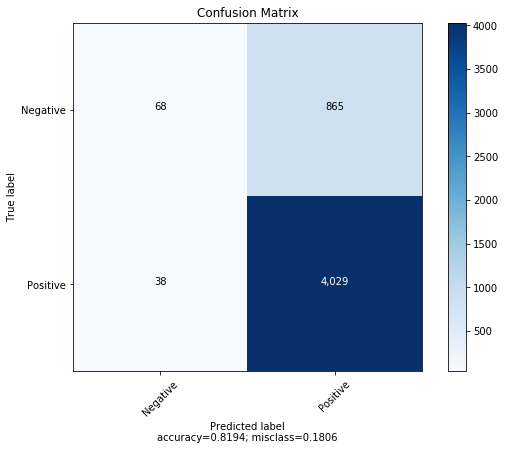

In [132]:
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

In [133]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [134]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format( TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format( TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format( FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format( FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format( TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format( TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format( (TP+TN)/(TP+FP+FN+TN))

In [135]:
Recall=recall_score(Y_test, pred, average='micro') 

In [136]:
Precision=precision_score(Y_test, pred, average='micro')

In [137]:
F1_Score=f1_score(Y_test, pred, average='weighted')

In [138]:
pd.crosstab(Y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,negative,positive,All
True,,,
negative,68,865,933
positive,38,4029,4067
All,106,4894,5000


In [139]:
x.add_row(["Bag of Words","kd_tree",17,TPR,TNR,'{0:.2f}'.format(Precision),'{0:.2f}'.format(Recall),'{0:.2f}'.format(F1_Score),FPR,FNR,PPV,NPV,ACC])

In [140]:
print(x)

|    Model     | Algorithm |  K  |  TPR   |  TNR  | Precision | Recall | F1-Score |  FPR   |  FNR  |  PPV   |  NPV   | Overall Accuracy (ACC) |
| Bag of Words |  kd_tree  |  17 | 99.07% | 7.29% |    0.82   |  0.82  |   0.76   | 92.71% | 0.93% | 82.33% | 64.15% |         81.94%         |


In [141]:
print(classification_report(Y_test, pred))  

             precision    recall  f1-score   support

   negative       0.64      0.07      0.13       933
   positive       0.82      0.99      0.90      4067

avg / total       0.79      0.82      0.76      5000



In [142]:
with open('Output_kd-tree.txt', 'w') as w:
    w.write(str(x))

## TF - IDF

In [143]:
tf_transformer = TfidfVectorizer(ngram_range=(1,2))
TF_vector=tf_transformer.fit(X_train_data['CleanedText'].values)
TF_train_Vector = TF_vector.transform(X_train_data['CleanedText'].values)
TF_train_Vector.shape

(20834, 427963)

In [144]:
TF_cv_Vector = TF_vector.transform(X_cv_data['CleanedText'].values)
TF_cv_Vector.shape

(4166, 427963)

In [145]:
TF_test_Vector = TF_vector.transform(X_test_data['CleanedText'].values)
TF_test_Vector.shape

(5000, 427963)

In [146]:
print(TF_train_Vector.shape)
print(TF_cv_Vector.shape)
print(TF_test_Vector.shape)
print('-------------------')
print(Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)

(20834, 427963)
(4166, 427963)
(5000, 427963)
-------------------
(20834,)
(4166,)
(5000,)


In [147]:
svd = TruncatedSVD(n_components=20)

In [148]:
svd.fit(TF_train_Vector)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
       random_state=None, tol=0.0)

In [149]:
TF_svd_Train=svd.transform(TF_train_Vector)

In [150]:
TF_svd_Train.shape

(20834, 20)

In [151]:
TF_svd_CV=svd.transform(TF_cv_Vector)

In [152]:
TF_svd_Test=svd.transform(TF_test_Vector)

In [153]:
start_time_code = time.time()
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree")

    # fitting the model on crossvalidation train
    knn.fit(TF_svd_Train, Y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(TF_svd_CV)

    # evaluate CV accuracy
    tf_acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %0.2f%%' % (i, tf_acc))
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")


CV accuracy for k = 1 is 78.06%

CV accuracy for k = 3 is 81.04%

CV accuracy for k = 5 is 82.72%

CV accuracy for k = 7 is 82.53%

CV accuracy for k = 9 is 82.53%

CV accuracy for k = 11 is 82.55%

CV accuracy for k = 13 is 82.93%

CV accuracy for k = 15 is 82.74%

CV accuracy for k = 17 is 82.69%

CV accuracy for k = 19 is 82.81%

CV accuracy for k = 21 is 82.74%

CV accuracy for k = 23 is 82.84%

CV accuracy for k = 25 is 82.72%

CV accuracy for k = 27 is 82.81%

CV accuracy for k = 29 is 82.79%
Running Time for code execution 46.00462007522583 secs


In [154]:
knn = KNeighborsClassifier(17,algorithm="kd_tree")
knn.fit(TF_svd_Train,Y_train)
pred = knn.predict(TF_svd_Test)
tf_test_acc = accuracy_score(Y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 17 is %0.2f%%' % (tf_test_acc))


****Test accuracy for k = 17 is 82.64%


In [155]:
Conf_matrix=confusion_matrix(Y_test, pred)

In [156]:
Conf_matrix

array([[ 102,  831],
       [  37, 4030]])

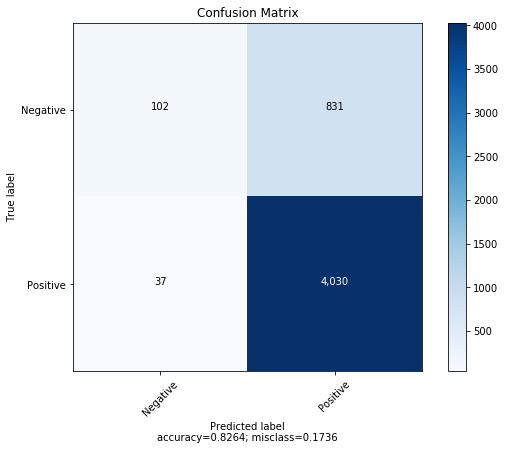

In [157]:
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

In [158]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [159]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format( TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format( TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format( FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format( FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format( TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format( TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format( (TP+TN)/(TP+FP+FN+TN))

In [160]:
Recall=recall_score(Y_test, pred, average='micro') 

In [161]:
Precision=precision_score(Y_test, pred, average='micro')

In [162]:
F1_Score=f1_score(Y_test, pred, average='weighted')

In [163]:
pd.crosstab(Y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,negative,positive,All
True,,,
negative,102,831,933
positive,37,4030,4067
All,139,4861,5000


In [164]:
x.add_row([" TF - IDF ","Kd_tree",17,TPR,TNR,'{0:.2f}'.format(Precision),'{0:.2f}'.format(Recall),'{0:.2f}'.format(F1_Score),FPR,FNR,PPV,NPV,ACC])

In [165]:
print(classification_report(Y_test, pred))  

             precision    recall  f1-score   support

   negative       0.73      0.11      0.19       933
   positive       0.83      0.99      0.90      4067

avg / total       0.81      0.83      0.77      5000



In [166]:
print(x)

|    Model     | Algorithm |  K  |  TPR   |  TNR   | Precision | Recall | F1-Score |  FPR   |  FNR  |  PPV   |  NPV   | Overall Accuracy (ACC) |
| Bag of Words |  kd_tree  |  17 | 99.07% | 7.29%  |    0.82   |  0.82  |   0.76   | 92.71% | 0.93% | 82.33% | 64.15% |         81.94%         |
|   TF - IDF   |  Kd_tree  |  13 | 99.09% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.91% | 82.90% | 73.38% |         82.64%         |


## Average W2V

In [167]:
# Train your own Word2Vec model using your own text corpus for Training Dataset
i=0
list_of_sent=[]
for sent in X_train_data['CleanedText'].values:
    list_of_sent.append(sent.split())

# min_count = 5 considers only words that occured atleast 5 times
Trained_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

w2v_words = list(Trained_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6969
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'turn', 'whole', 'school', 'purchas']


In [168]:
# average Word2Vec
# compute average word2vec for each review.
Trained_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Trained_vectors.append(sent_vec)
print(len(Trained_vectors))

20834


In [169]:
Train_X=Trained_vectors

In [170]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_cv=[]
for sent in X_cv_data['CleanedText'].values:
    list_of_sent_cv.append(sent.split())

In [171]:
# average Word2Vec
# compute average word2vec for each review.
Cv_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Cv_vectors.append(sent_vec)
print(len(Cv_vectors))

4166


In [172]:
CV_X=Cv_vectors

In [173]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_test=[]
for sent in X_test_data['CleanedText'].values:
    list_of_sent_test.append(sent.split())

In [174]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))

5000


In [175]:
Test_X=test_vectors

In [176]:
print (len(Train_X))
print(len(CV_X))
print(len(Test_X))
print('-----------------')
print (Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)

20834
4166
5000
-----------------
(20834,)
(4166,)
(5000,)


In [177]:
start_time_code = time.time()
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree")

    # fitting the model on crossvalidation train
    knn.fit(Train_X, Y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(CV_X)

    # evaluate CV accuracy
    train_acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %0.2f%%' % (i, train_acc))
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")


CV accuracy for k = 1 is 79.28%

CV accuracy for k = 3 is 82.45%

CV accuracy for k = 5 is 83.39%

CV accuracy for k = 7 is 83.27%

CV accuracy for k = 9 is 83.22%

CV accuracy for k = 11 is 83.44%

CV accuracy for k = 13 is 83.34%

CV accuracy for k = 15 is 83.41%

CV accuracy for k = 17 is 83.39%

CV accuracy for k = 19 is 83.27%

CV accuracy for k = 21 is 83.34%

CV accuracy for k = 23 is 83.37%

CV accuracy for k = 25 is 83.29%

CV accuracy for k = 27 is 83.29%

CV accuracy for k = 29 is 83.27%
Running Time for code execution 153.1801438331604 secs


In [178]:
# Since the train accuracy for k is the same from k=3 to k=29. so the smallest k at maximum accuracy is the best i.e. k=3
knn = KNeighborsClassifier(11,algorithm="kd_tree")
knn.fit(Train_X,Y_train)
pred = knn.predict(Test_X)
test_acc = accuracy_score(Y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 11 is %0.2f%%' % (test_acc))


****Test accuracy for k = 11 is 83.30%


In [179]:
Conf_matrix=confusion_matrix(Y_test, pred)

In [180]:
Conf_matrix

array([[ 169,  764],
       [  71, 3996]])

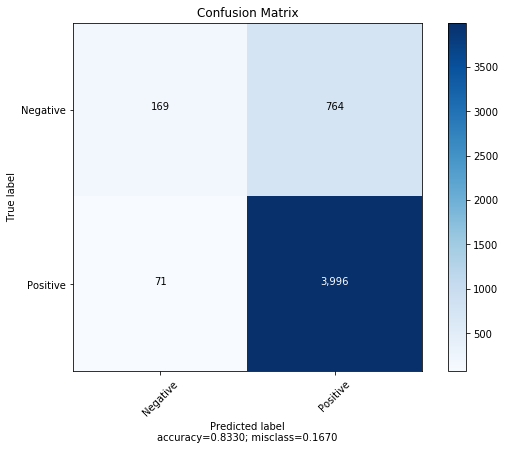

In [181]:
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

In [182]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [183]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format( TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format( TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format( FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format( FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format( TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format( TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format( (TP+TN)/(TP+FP+FN+TN))

In [184]:
Recall=recall_score(Y_test, pred, average='micro') 

In [185]:
Precision=precision_score(Y_test, pred, average='micro')

In [186]:
F1_Score=f1_score(Y_test, pred, average='weighted')

In [187]:
pd.crosstab(Y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,negative,positive,All
True,,,
negative,169,764,933
positive,71,3996,4067
All,240,4760,5000


In [188]:
x.add_row([" Average W2V ","Kd_tree",11,TPR,TNR,'{0:.2f}'.format(Precision),'{0:.2f}'.format(Recall),'{0:.2f}'.format(F1_Score),FPR,FNR,PPV,NPV,ACC])

In [189]:
print(classification_report(Y_test, pred))  

             precision    recall  f1-score   support

   negative       0.70      0.18      0.29       933
   positive       0.84      0.98      0.91      4067

avg / total       0.81      0.83      0.79      5000



In [190]:
print(x)

|     Model     | Algorithm |  K  |  TPR   |  TNR   | Precision | Recall | F1-Score |  FPR   |  FNR  |  PPV   |  NPV   | Overall Accuracy (ACC) |
|  Bag of Words |  kd_tree  |  17 | 99.07% | 7.29%  |    0.82   |  0.82  |   0.76   | 92.71% | 0.93% | 82.33% | 64.15% |         81.94%         |
|    TF - IDF   |  Kd_tree  |  13 | 99.09% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.91% | 82.90% | 73.38% |         82.64%         |
|  Average W2V  |  Kd_tree  |  11 | 98.25% | 18.11% |    0.83   |  0.83  |   0.79   | 81.89% | 1.75% | 83.95% | 70.42% |         83.30%         |


## TF-IDF weighted Word2Vec

In [53]:
# TF-IDF weighted Word2Vec
tfidf_feat = TF_vector.get_feature_names() # tfidf words/col-names

In [54]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
start_time_code = time.time()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = TF_train_Vector[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

Running Time for code execution 13474.992048978806 secs


In [55]:
Train_X=tfidf_sent_vectors

In [56]:
df = pd.DataFrame.from_records(Train_X)
df.to_csv('TF-IDF_W2V_Train_kd.csv',index=None)

In [191]:
Train_X = pd.read_csv("TF-IDF_W2V_Train_kd.csv") 

In [57]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
start_time_code = time.time()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = TF_cv_Vector[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

Running Time for code execution 2435.09094786644 secs


In [58]:
CV_X=tfidf_sent_vectors

In [59]:
df = pd.DataFrame.from_records(CV_X)
df.to_csv('TF-IDF_W2V_CV_Kd.csv',index=None)

In [192]:
CV_X = pd.read_csv("TF-IDF_W2V_CV_Kd.csv") 

In [60]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
start_time_code = time.time()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = TF_test_Vector[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

Running Time for code execution 2871.7937688827515 secs


In [61]:
Test_X=tfidf_sent_vectors

In [62]:
df = pd.DataFrame.from_records(Test_X)
df.to_csv('TF-IDF_W2V_Test_Kd.csv',index=None)

In [193]:
Test_X = pd.read_csv("TF-IDF_W2V_Test_Kd.csv") 

In [194]:
start_time_code = time.time()
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree")

    # fitting the model on crossvalidation train
    knn.fit(Train_X, Y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(CV_X)

    # evaluate CV accuracy
    train_acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %0.2f%%' % (i, train_acc))
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")


CV accuracy for k = 1 is 77.87%

CV accuracy for k = 3 is 81.06%

CV accuracy for k = 5 is 82.53%

CV accuracy for k = 7 is 82.67%

CV accuracy for k = 9 is 83.37%

CV accuracy for k = 11 is 83.15%

CV accuracy for k = 13 is 83.08%

CV accuracy for k = 15 is 82.89%

CV accuracy for k = 17 is 82.89%

CV accuracy for k = 19 is 82.93%

CV accuracy for k = 21 is 82.89%

CV accuracy for k = 23 is 82.93%

CV accuracy for k = 25 is 82.91%

CV accuracy for k = 27 is 83.03%

CV accuracy for k = 29 is 82.86%
Running Time for code execution 135.67332410812378 secs


In [195]:
# Since the train accuracy for k is the same from k=3 to k=29. so the smallest k at maximum accuracy is the best i.e. k=3
knn = KNeighborsClassifier(23,algorithm="kd_tree")
knn.fit(Train_X,Y_train)
pred = knn.predict(Test_X)
test_acc = accuracy_score(Y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 23 is %0.2f%%' % (test_acc))


****Test accuracy for k = 23 is 82.84%


In [196]:
Conf_matrix=confusion_matrix(Y_test, pred)

In [197]:
Conf_matrix

array([[ 102,  831],
       [  27, 4040]])

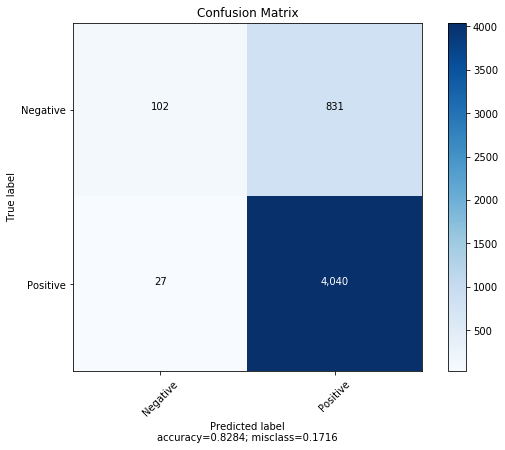

In [198]:
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

In [199]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [200]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format( TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format( TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format( FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format( FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format( TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format( TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format( (TP+TN)/(TP+FP+FN+TN))

In [201]:
Recall=recall_score(Y_test, pred, average='micro') 

In [202]:
Precision=precision_score(Y_test, pred, average='micro')

In [203]:
F1_Score=f1_score(Y_test, pred, average='weighted')

In [204]:
pd.crosstab(Y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,negative,positive,All
True,,,
negative,102,831,933
positive,27,4040,4067
All,129,4871,5000


In [205]:
x.add_row([" TF - IDF Weighted W2V ","Kd_tree",23,TPR,TNR,'{0:.2f}'.format(Precision),'{0:.2f}'.format(Recall),'{0:.2f}'.format(F1_Score),FPR,FNR,PPV,NPV,ACC])

In [206]:
print(classification_report(Y_test, pred))  

             precision    recall  f1-score   support

   negative       0.79      0.11      0.19       933
   positive       0.83      0.99      0.90      4067

avg / total       0.82      0.83      0.77      5000



In [299]:
print(x)

|          Model          | Algorithm |  K  |  TPR   |  TNR   | Precision | Recall | F1-Score |  FPR   |  FNR  |  PPV   |  NPV   | Overall Accuracy (ACC) |
|       Bag of Words      |  kd_tree  |  17 | 99.07% | 7.29%  |    0.82   |  0.82  |   0.76   | 92.71% | 0.93% | 82.33% | 64.15% |         81.94%         |
|         TF - IDF        |  Kd_tree  |  13 | 99.09% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.91% | 82.90% | 73.38% |         82.64%         |
|       Average W2V       |  Kd_tree  |  11 | 98.25% | 18.11% |    0.83   |  0.83  |   0.79   | 81.89% | 1.75% | 83.95% | 70.42% |         83.30%         |
|  TF - IDF Weighted W2V  |  Kd_tree  |  23 | 99.34% | 10.93% |    0.83   |  0.83  |   0.77   | 89.07% | 0.66% | 82.94% | 79.07% |         82.84%         |
|       Bag of Words      |   Brute   |  15 | 99.93% | 1.87%  |    0.82   |  0.82  |   0.74   | 98.13% | 0.07% | 81.68% | 85.29% |         81.70%         |
|         TF - IDF        |   Brute   |  11 | 99.04% | 12.27% | 

In [300]:
with open('Output.txt', 'w') as w:
    w.write(str(x))

## Conclusion
            1. Of all the Word to vector conversion models, TF - IDF got more True Positive Rate and True Negative Rate in 'Brute' and 'Kd-tree'